# Code for interacting with API of openFDA

## Plan
In this project, we are looking for device adverse events. We are particularly interested in:
    - Cause of failure
    - Date of failure (ie age of device)
We want to see which is the most common cause for given device to fail and at which stage of use this occurs.
Relevant fields could be (for full reference see https://open.fda.gov/device/event/reference/):
##### Event
device_date_of_manufacturer
date_of_event, date_report, date_received
previous_use_code, remedial_action
single_use_flag
##### Source
reprocessed_and_reused_flag
##### Device
device.generic_name
device.expiration_date_of_device, device.device_age_text
device.implant_flag, device.date_removed_flag
device.manufacturer_d_name, device.manufacturer_d_state, device.manufacturer_d_country
##### Patient
patient.sequence_number_outcome, patient.sequence_number_treatment
##### Report Text
mdr_text.text, mdr_text.text_type_code
##### Reporter Dependent Fields
report_date
event_location
manufacturer_name, manufacturer_country
manufacturer_g1_name, manufacturer_g1_state
##### OpenFDA fields
device_class
##### Further interesting fields:
Source: reporter_occupation_code
Device: device.device_operator

In [1]:
# Import modules
import numpy as np
import pandas as pd
import json
import requests
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, MiniBatchKMeans
import logging
import sys
from time import time
from datetime import datetime, timedelta

In [2]:
# Build base query
baseurl = 'https://api.fda.gov/device/event.json?'
time_period = 7
initial_date = "20150101"
final_date = datetime.strptime("20150701", "%Y%m%d")
skip = 0
limit = 100

apikey = ''
with open('apikey.txt', 'r') as myfile:
    apikey = myfile.read().replace('\n', '')

### Features to check for existence

In [3]:
list_features = ['device_date_of_manufacturer', 
                 'date_of_event',
                 #'date_report',
                 #'date_received',
                 'previous_use_code',
                 #'remedial_action',
                 #'single_use_flag',
                 #'reprocessed_and_reused_flag',
                 #'reporter_occupation_code',
                 #'device.date_received',
                 #'device.generic_name' # this allows for empty string! 
                ]

# possibility to further narrow donw the search
# list_features_specific = ['device.openfda.device_name:"sensor"', 
#                   #'device.implant_flag:"Y"',
#                   #'previous_use_code:"I"', # I - initial use, R - reuse, U - unknown, * - invalid data
#                   #'device.manufacturer_d_country:"US"' # SZ - Switzerland
#                  ]

### List of usable device names 

In [4]:
list_device_names = ["pump",
                    "sensor",
                    "prosthesis",
                    "defibrilator",
                    "pacemaker",
                    "catheter",
                    "electrode",
                    #"wearable",
                     "stent",
                     "ray",
                     "ventilator",
                     "bed",
                     "implant",
                     "lens",
                     #"mds" # https://www.cancer.org/cancer/myelodysplastic-syndrome/about/what-is-mds.html
                     "dialysis",
                     "graft",
                    ]
                  

## Build full query

In [6]:
start_date = datetime.strptime(initial_date, "%Y%m%d")
end_date = start_date +  timedelta(days=time_period)
device_name = list_device_names[4]
results = []

while True:
    skip = 0
    
    while (skip<=5000):
        query = 'search=device.generic_name:'+device_name+'+AND+'
        # adding date range
        start = str(start_date.date()).replace("_", "")
        end = str(end_date.date()).replace("_", "")
        query = query+"date_of_event:[\""+start+"\""+"+TO+"+"\""+end+"\"]"
        
        # checking features for existence
        for x in list_features:
            query = query + "+AND+_exists_:" + x
            
        # # Possibility to furhter narrow down the search
        # for y in list_features_specific:
        #     query = query + "+AND+" + y

        
        q1 = baseurl + 'api_key=' + apikey + '&' + query + '&' + 'limit=' + str(limit) + '&' + 'skip=' + str(skip)
        dq1 = requests.get(q1)
        # dq1.json()['results']
        data = json.loads(dq1.text)

        if "results" in data:
            result = data['results']
            results = results + result
            print(len(results))
            skip = skip + limit
        else:
            break

    print("Week Done")
    start_date = end_date + timedelta(days=1)
    end_date = start_date +  timedelta(days=time_period)
    if start_date > final_date:
        break
        
    if end_date > final_date:
        end_date = final_date

'''
# adding date range
query = query+"date_of_event:[\""+start_date+"\""+"+TO+"+"\""+end_date+"\"]"

# checking features for existence
for x in list_features:
    query = query + "+AND+_exists_:" + x

# # Possibility to furhter narrow down the search
# for y in list_features_specific:
#     query = query + "+AND+" + y

# Search for specific device, see the list abvoe
name_query = '+AND+device.openfda.device_name:' + device_name ;

# Construct final query
# q1 = baseurl + 'api_key=' + apikey + '&' + query + '&' + 'limit=' + str(limit)
q2 = baseurl + 'api_key=' + apikey + '&' + query + name_query + '&' +'limit=' + str(limit)
'''

100
200
300
400
448
Week Done
548
648
748
848
948
1023
Week Done
1123
1223
1323
1423
1434
Week Done
1534
1634
1734
1834
1878
Week Done
1978
2078
2178
2278
2378
Week Done
2478
2578
2678
2778
2851
Week Done
2951
3051
3151
3251
3343
Week Done
3443
3543
3643
3743
3843
3875
Week Done
3975
4075
4175
4275
4355
Week Done
4455
4555
4655
4755
4831
Week Done
4931
5031
5131
5231
5312
Week Done
5412
5512
5612
5712
5812
5905
Week Done
6005
6105
6205
6305
6405
6457
Week Done
6557
6657
6757
6857
6957
7036
Week Done
7136
7236
7336
7436
7536
7552
Week Done
7652
7752
7852
7952
8052
8136
Week Done
8236
8336
8436
8536
8636
8642
Week Done
8742
8842
8942
9042
9142
9151
Week Done
9251
9351
9451
9551
9651
9674
Week Done
9774
9874
9974
10074
10174
10202
Week Done
10302
10402
10502
10602
10702
10769
Week Done
10869
10969
11069
11169
11269
11352
Week Done
11452
11552
11652
11735
Week Done


'\n# adding date range\nquery = query+"date_of_event:[""+start_date+"""+"+TO+"+"""+end_date+""]"\n\n# checking features for existence\nfor x in list_features:\n    query = query + "+AND+_exists_:" + x\n\n# # Possibility to furhter narrow down the search\n# for y in list_features_specific:\n#     query = query + "+AND+" + y\n\n# Search for specific device, see the list abvoe\nname_query = \'+AND+device.openfda.device_name:\' + device_name ;\n\n# Construct final query\n# q1 = baseurl + \'api_key=\' + apikey + \'&\' + query + \'&\' + \'limit=\' + str(limit)\nq2 = baseurl + \'api_key=\' + apikey + \'&\' + query + name_query + \'&\' +\'limit=\' + str(limit)\n'

In [6]:
''' # Checking the number of data points for each device
dq = requests.get(q2)
# dq1.json()['results']
data = json.loads(dq.text)
number = data['meta']['results']['total'] # check number of matching entries
results = data['results']
number
'''

" # Checking the number of data points for each device\ndq = requests.get(q2)\n# dq1.json()['results']\ndata = json.loads(dq.text)\nnumber = data['meta']['results']['total'] # check number of matching entries\nresults = data['results']\nnumber\n"

In [7]:
# Can also spare some structuring effort when loading data by calling normalization method
# dftest = pd.io.json.json_normalize(results)
len(results)

11735

In [8]:
# check that you obtained what you expected
results[3]

{'adverse_event_flag': 'Y',
 'date_manufacturer_received': '20150224',
 'date_of_event': '20150107',
 'date_received': '20150126',
 'date_report': '20150224',
 'device': [{'brand_name': 'CAPSUREEPI',
   'catalog_number': '4968-25',
   'date_received': '20150126',
   'date_removed_flag': '',
   'date_returned_to_manufacturer': '20150112',
   'device_age_text': 'DA',
   'device_availability': 'Device was returned to manufacturer',
   'device_evaluated_by_manufacturer': 'Y',
   'device_event_key': '',
   'device_operator': 'LAY USER/PATIENT',
   'device_report_product_code': 'DTB',
   'device_sequence_number': ' 1.0',
   'expiration_date_of_device': '20121128',
   'generic_name': 'ELECTRODE, PACEMAKER, PERMANENT',
   'implant_flag': '',
   'lot_number': '',
   'manufacturer_d_address_1': '8200 CORAL SEA STREET NE',
   'manufacturer_d_address_2': '',
   'manufacturer_d_city': 'MOUNDS VIEW',
   'manufacturer_d_country': 'US',
   'manufacturer_d_name': 'MEDTRONIC, INC.',
   'manufacturer_d_p

###  Fields of Interest

In [39]:
fois_result = ['device_date_of_manufacturer',
               'date_of_event',
               'previous_use_code',
               'single_use_flag',
               'reprocessed_and_reused_flag',
               #'reporter_occupation_code'
              ]
fois_device = [#'generic_name', 
               'expiration_date_of_device', 
               #'device_age_text', 
               #'implant_flag', 
               #'date_removed_flag', 
               #'manufacturer_d_name', 
               #'manufacturer_d_state',
               'manufacturer_d_country',
               #'device_operator'
              ]
fois_patient = [#'sequence_number_outcome', # problematic to factorize as it contains lists
                #'sequence_number_treatment' # problematic to factorize as it contains lists
              ]
fois_mdrText = ['text',
                'text_type_code']
fois_openfda = ['device_name',
                'device_class',
                'medical_specialty_description']

# device = data['results'][0]['device'][0]
device = [x['device'][0] for x in results]
# patient = data['results'][0]['patient'][0]
patient = [x['patient'][0] for x in results]
# mdrText = data['results'][0]['mdr_text'][0] # there may be more items in the list! 
mdrText = [x['mdr_text'] for x in results]
#mdrText = [y['text'] for y in [x['mdr_text'][0] for x in data['results']]]
# openfda = data['results'][0]['device'][0]['openfda']
openfda = [x['device'][0]['openfda'] for x in results]

In [40]:
# Create sub dataframes for non-multiple columns
df_results = pd.DataFrame(results, index = range(len(results)), columns = fois_result)
df_openfda = pd.DataFrame(openfda, index = range(len(results)),columns = fois_openfda)
df_device = pd.DataFrame(device, index = range(len(results)),columns = fois_device)
df_patient = pd.DataFrame(patient, index = range(len(results)),columns = fois_patient)

In [41]:
# Pull out all relevant text fields
fillDic = {'mdr_text_key': '', 'patient_sequence_number': '', 'text': np.nan, 'text_type_code': np.nan}
a = [x[0] if len(x) > 0 else fillDic for x in mdrText]
b = [x[1] if len(x) > 1 else fillDic for x in mdrText]
c = [x[2] if len(x) > 2 else fillDic for x in mdrText] 


a = pd.DataFrame(a, index = range(len(results)),columns = fois_mdrText)
b = pd.DataFrame(b, index = range(len(results)),columns = fois_mdrText)
c = pd.DataFrame(c, index = range(len(results)),columns = fois_mdrText)

In [42]:
# Rename duplicate columns:
fois_mdrText_a = [x + '_0' for x in fois_mdrText]
fois_mdrText_b = [x + '_1' for x in fois_mdrText]
fois_mdrText_c = [x + '_2' for x in fois_mdrText]

columns_a = dict(zip(fois_mdrText, fois_mdrText_a))
columns_b = dict(zip(fois_mdrText, fois_mdrText_b))
columns_c = dict(zip(fois_mdrText, fois_mdrText_c))

a.rename(columns = columns_a, inplace = True)
b.rename(columns = columns_b, inplace = True)
c.rename(columns = columns_c, inplace = True)

# I haven't seen a four-field entry. If there were some, we would need to deal with them in smarter way

In [79]:
# Construct final data frame
df_mdrText = pd.concat([a, b, c], axis = 1)

# Concatenate into final dataframe
df = pd.concat([df_results, df_device, df_patient, df_mdrText, df_openfda], axis = 1)

In [80]:
# Determine age of device in days
df['age_of_device_days'] = pd.to_datetime(df['date_of_event'], format='%Y%m%d') \
- pd.to_datetime(df['device_date_of_manufacturer'], format='%Y%m%d')

# Determine timedelta from manufacture to specified expiry date
df['days_to_expiry'] = pd.to_datetime(df['expiration_date_of_device'], format='%Y%m%d') \
- pd.to_datetime(df['device_date_of_manufacturer'], format='%Y%m%d')
df = df.drop(['date_of_event','device_date_of_manufacturer', 'expiration_date_of_device'], axis = 1)

In [45]:
# Write to file for manual inspection

# file_name = device_name + '_mdrTextClasses.csv'
# # cols_to_write = ['text', 'text_type_code', 'device_name',
# #        'medical_specialty_description', 'age_of_device_days']
# df.to_csv(file_name, mode = 'w', encoding='utf-8')

#### Check that you have what you expect

In [81]:
df.columns

Index(['previous_use_code', 'single_use_flag', 'reprocessed_and_reused_flag',
       'manufacturer_d_country', 'text_0', 'text_type_code_0', 'text_1',
       'text_type_code_1', 'text_2', 'text_type_code_2', 'device_name',
       'device_class', 'medical_specialty_description', 'age_of_device_days',
       'days_to_expiry'],
      dtype='object')

In [82]:
df.sample(3)

,previous_use_code,single_use_flag,reprocessed_and_reused_flag,manufacturer_d_country,text_0,text_type_code_0,text_1,text_type_code_1,text_2,text_type_code_2,device_name,device_class,medical_specialty_description,age_of_device_days,days_to_expiry
6638,R,N,N,US,PRODUCT EVENT SUMMARY: ANALYSIS CONFIRMED THE ...,Additional Manufacturer Narrative,IT WAS REPORTED THAT THE RADIO FREQUENCY (RF) ...,Description of Event or Problem,THE INFORMATION SUBMITTED REFLECTS ALL RELEVAN...,Additional Manufacturer Narrative,"Programmer, Pacemaker",3,Cardiovascular,1331 days,NaT
51,I,Y,N,US,(B)(4).,Additional Manufacturer Narrative,"IT WAS REPORTED THAT IN CLINIC, THE PULSE GENE...",Description of Event or Problem,NaN,NaN,"Implantable Pulse Generator, Pacemaker (Non-Crt)",3,Unknown,3064 days,562 days
6168,I,Y,N,US,IT WAS REPORTED THAT THE RIGHT ATRIAL (RA) LEA...,Description of Event or Problem,THE INFORMATION SUBMITTED REFLECTS ALL RELEVAN...,Additional Manufacturer Narrative,NaN,NaN,Permanent Pacemaker Electrode,3,Cardiovascular,67 days,719 days


### Factorize selected columns
This will convert nominal (string) entries into categorical.

In [83]:
# Columns that we want to translate into categories
factCols = ['previous_use_code',
            'single_use_flag',
            'reprocessed_and_reused_flag',
            #'reporter_occupation_code',
            #'implant_flag',
            #'manufacturer_d_name',
            'manufacturer_d_country',
            #'device_operator',
            #'sequence_number_outcome', # problematic to factorize as it contains lists
            #'sequence_number_treatment', # problematic to factorize as it contains lists
            'text_type_code_0',
            'text_type_code_1', 
            'text_type_code_2',
            'device_name',
            'medical_specialty_description']

# copy dataframe to preserve original;
df1 = df.copy()

# This also works but will not assign consistent labeling across multiple columns
df1[factCols] = df1[factCols].apply(lambda x: pd.factorize(x)[0])

In [35]:
# # This will allow you to have consistency for columns that should contain same categories. Ideally avoid using this by removing
# the
# # http://stackoverflow.com/questions/39390160/pandas-factorize-on-an-entire-data-frame
# def categorise(df):
#     categories = {k: v for v, k in enumerate(df.stack().unique())}
#     return df.replace(categories)
# df[factCols] = categorise(df[factCols])

# Later we may need to adress the issue of rather random (although consistent) numbering of categories. Both are not currently crucial.

In [84]:
# If using pd.factorize, this is likely redundant (but not harmful)

# http://stackoverflow.com/questions/28910851/python-pandas-changing-some-column-types-to-categories
# http://pandas.pydata.org/pandas-docs/stable/categorical.html

# df[factCols2].astype('category')
df1[factCols] = df1[factCols].apply(lambda x: x.astype('category'))

##### Check that you have what you want

In [85]:
df1.sample(2)

,previous_use_code,single_use_flag,reprocessed_and_reused_flag,manufacturer_d_country,text_0,text_type_code_0,text_1,text_type_code_1,text_2,text_type_code_2,device_name,device_class,medical_specialty_description,age_of_device_days,days_to_expiry
3513,0,0,0,0,"ALL INFORMATION PROVIDED BY MANUFACTURER, NO M...",0,THIS REPORT IS TO ADVISE OF AN EVENT OBSERVED ...,0,NaN,-1,4,3,0,409 days,563 days
5897,0,0,0,0,IT WAS REPORTED THAT THE RIGHT VENTRICULAR (RV...,1,.,1,NaN,-1,1,3,1,1932 days,721 days


## Convert mdr_text columns into class assignements

In [86]:
# estabilish variables
lsa = 4
n_features = 10000
k = 5

# pull out relevant subset
# here we use regular expression to match all column names starting with "text_#" (ie we pick 3 columns)
df_text = df1[df1.columns[df1.columns.to_series().str.contains('^text_[0-9]$')]]

In [87]:
# comvert text data into single dimensional iterable [list]

# save structuring information for possible later use
IDXS = df_text.index
COLS = df_text.columns
# join texts into one string, droping nans
df_text_cat = df_text.apply(lambda x: '; '.join(x.dropna().values.tolist()), axis=1)
text_np_cat = df_text_cat.values

# text_np = df_text.values
# text_np_cat = ['; '.join(map(str, x)) for x in text_np]

#### Do Tfidf vectorization

In [88]:
# Do Tfidf vectorization
t0 = time()
vectorizer = TfidfVectorizer(max_df=0.5, max_features=n_features,
                                 min_df=2, stop_words='english',
                                 use_idf=True)
X = vectorizer.fit_transform(text_np_cat)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)

done in 1.318166s
n_samples: 11735, n_features: 4123


#### Do clustering

In [89]:
#clustering
km = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=False)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10, n_clusters=5,
        n_init=1, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=False)
done in 0.277s


In [90]:
# See the cluster assignements
uniqs, uniq_counts = np.unique(km.labels_, return_counts = True)
dict(zip(uniqs,uniq_counts))

{0: 1744, 1: 3670, 2: 1446, 3: 2163, 4: 2712}

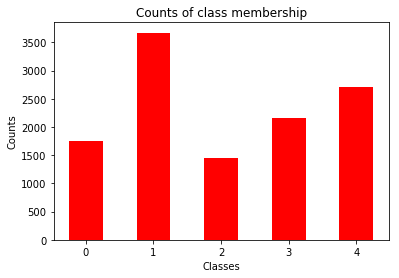

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline
width = 0.5       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(uniqs, uniq_counts, width, color='r')

# add some text for labels, title and axes ticks
ax.set_ylabel('Counts')
ax.set_xlabel('Classes')
ax.set_title('Counts of class membership')
ax.set_xticks(uniqs)
plt.show()

##### Observe which classes you have actually obtained
Here you should be able to actually see a pattern beind those!
Try looking at some class and ranking words by occurance

In [111]:
#df[df.columns[df.columns.to_series().str.contains('^text_*')]][km.labels_ == 0].sample(2)
np.random.choice(text_np_cat[km.labels_ == 1], size = 4)

array([ 'THE INFORMATION SUBMITTED REFLECTS ALL RELEVANT DATA RECEIVED. IF ADDITIONAL RELEVANT INFORMATION IS RECEIVED, A SUPPLEMENTAL REPORT WILL BE SUBMITTED. CONCOMITANT MEDICAL PRODUCT: PRODUCT ID: ADDR01, IPG, IMPLANTED: 2007-(B)(6). (B)(4).; IT WAS REPORTED THAT DURING A ROUTINE DEVICE REPLACEMENT PROCEDURE, THE PHYSICIAN OBSERVED INSULATION DAMAGE ON THE RIGHT VENTRICULAR (RV) LEAD. THE LEAD WAS CAPPED AND REPLACED. NO PATIENT COMPLICATIONS HAVE BEEN REPORTED AS A RESULT OF THIS EVENT.',
       'THE INFORMATION SUBMITTED REFLECTS ALL RELEVANT DATA RECEIVED. IF ADDITIONAL RELEVANT INFORMATION IS RECEIVED, A SUPPLEMENTAL REPORT WILL BE SUBMITTED. (B)(4).; IT WAS REPORTED BY THE PATIENT\'S PARENT THAT THE DEVICE SYSTEM WAS REPLACED BECAUSE "SOMETHING WENT WRONG". ADDITIONAL INFORMATION OBTAINED REPORTED THERE WAS A VISIBLE FRACTURE OF THE VENTRICULAR LEAD. IT WAS FURTHER REPORTED THAT THERE WAS HIGH ATRIAL LEAD CAPTURE THRESHOLD AND THAT THE LEAD WAS NOT CAPTURING APPROPRIATELY. TH

#### Replace the former text values with a class assigenemnt and check
here we use regular expression to match all column names starting with "text" (ie we drop alltogether 6 columns)

In [92]:
df2 = df1.drop(df1.columns[df1.columns.to_series().str.contains('^text_*')], axis = 1)
df2['mdr_text_class'] = km.labels_

In [93]:
df[df2['mdr_text_class'] == 1].sample(3)

,previous_use_code,single_use_flag,reprocessed_and_reused_flag,manufacturer_d_country,text_0,text_type_code_0,text_1,text_type_code_1,text_2,text_type_code_2,device_name,device_class,medical_specialty_description,age_of_device_days,days_to_expiry
3640,I,Y,N,US,"IT WAS REPORTED THAT DURING IMPLANT ATTEMPT, T...",Description of Event or Problem,THE INFORMATION SUBMITTED REFLECTS ALL RELEVAN...,Additional Manufacturer Narrative,NaN,NaN,Permanent Pacemaker Electrode,3,Cardiovascular,1323 days,1461 days
9643,I,Y,N,US,THE INFORMATION SUBMITTED REFLECTS ALL RELEVAN...,Additional Manufacturer Narrative,IT WAS REPORTED THAT DURING A FOLLOW-UP VISIT ...,Description of Event or Problem,NaN,NaN,Permanent Pacemaker Electrode,3,Cardiovascular,169 days,722 days
10452,I,Y,N,US,IT WAS REPORTED THAT THE LEAD AND DEVICE WERE ...,Description of Event or Problem,THE INFORMATION SUBMITTED REFLECTS ALL RELEVAN...,Additional Manufacturer Narrative,NaN,NaN,Implantable Pacemaker Pulse-Generator,3,Cardiovascular,425 days,711 days


## Condition dataframe into ndarray
To feed it to sklearn

In [94]:
# X
df2['days_to_expiry'] = df2['days_to_expiry'].dt.days

X = df2.ix[:, df2.columns != 'age_of_device_days'].values
days = df2['age_of_device_days']

# y
y = days.dt.days.values

## Preprocess data

In [95]:
# load modules
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import KFold

# impute missing entries (due to missing expiry date) with mean
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_imputed = imp.fit_transform(X)

# Nomralize
X_normalized = preprocessing.normalize(X_imputed, norm='l2')

### Train a predictor

In [96]:
kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(X_normalized):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_normalized[train_index], X_normalized[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    print("Mean squared error: %.2f" % np.mean((regr.predict(X_test) - y_test) ** 2))

Mean squared error: 2635849.17
Mean squared error: 3256613.67
Mean squared error: 2614457.05
Mean squared error: 3006008.21
Mean squared error: 2641854.05
Mean squared error: 2588334.60
Mean squared error: 2790047.01
Mean squared error: 2714763.71
Mean squared error: 2413903.84
Mean squared error: 2580651.37


### Stop and think
    -We have only very few features that are very poor
    -So far we haven't tried training on some substantial amount of samples (e.g. 50'000 +)
    -Could perhaps branch off a bit and analyse something different?
        -Device provenance based on its type?
        -Date of expiry based on the type?
    